# Part of Speech Tagging with Recurrent Neural Networks

For this assignment, we will construct a recurrent neural network that annotates each word of a sentence with a POS tag. The task is a case of sequence labeling; a good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is [Alex Graves' dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand. 

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks, which accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors. 

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs. 
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing. A simple recurrent network (SRN) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ parametric tensors to be learned.

In [1]:
import torch
from typing import Tuple, List, Callable, Optional

### Assignment 2.0: Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs a SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

The function `step`, that accepts $x_t$ and $h_{t-1}$ and produces $h_t$ and $y_t$ is already implemented.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [2]:
class mySRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: Callable[[torch.FloatTensor], torch.FloatTensor],
                 output_activation: Callable[[torch.FloatTensor], torch.FloatTensor],
                 device: str):
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        
        # No bias (W_h*x_t, input to hidden)
        self.x_to_h = torch.nn.Linear(in_features=input_dim,  out_features=hidden_dim, bias=False).to(device)
        # Included bias (U_h*h_t-1 + b_h, hidden to hidden)
        self.h_to_h = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True).to(device)
        # Included bias (W_y*h_t + b_y, hidden to output)
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True).to(device)
        
    def step(self, x: torch.FloatTensor, h: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        # compute h_t
        next_h = self.x_to_h(x)  
        next_h = next_h + self.h_to_h(h)
        next_h = self.hidden_activation(next_h)
        
        # compute y_t
        next_y = self.h_to_y(next_h)
        next_y = self.output_activation(next_y)
        return (next_h, next_y)
        
    def forward(self, X: List[torch.FloatTensor], h: torch.FloatTensor) -> List[torch.FloatTensor]:
        Y = []
        for x in X:
            Y.append(self.step(x,h)[1])
        return Y
    

Let's get your implementation tested.

In [3]:
def test_mySRN() -> None:
    """
        Sanity check for your SRN implementation. Do not change any of the values here.
    """
    
    # set the random seed for reproducibility
    torch.random.manual_seed(42)
    # set some arbitrary sizes -- note that we can apply the SRN equations over many input sequences in parallel (batching)
    input_size, hidden_size, output_size, batch_size = 16, 48, 5, 32
    # instantiate the network with tanh and sigmoid as the activations for the hidden and output states
    srn = mySRN(input_size, hidden_size, output_size, torch.tanh, torch.sigmoid, 'cpu')
    # create an input sequence (32 is the batch size, 10 is the sequence length)
    test_x = [torch.rand(batch_size, input_size) for _ in range(10)]
    test_h = torch.rand(batch_size, hidden_size)
    # create an initial hidden vector
    test_y = srn(test_x, test_h)
    # assert len(X) == len(Y)
    if len(test_y) != len(test_x):
        raise AssertionError('Input and output sequences have unequal lengths')
    # assert shape correctness
    if (test_y[0].shape != (batch_size, output_size)):
        raise AssertionError('Output has the wrong shape')
    if float(test_y[0][1][0]) != 0.48402369022369385:
        print(float(test_y[0][1][0]))
        raise AssertionError('Output has the wrong value (check your equations!)')
    print('Everything ok!')

test_mySRN()

Everything ok!


In practice, we do not need to write our own functions for common RNN architectures. 
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/nn.html#rnn) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `'tanh'` or `'relu'` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

Read the documentation (!) for further details.

A brief example is given below.

In [4]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity='tanh')
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [5]:
del mySRN, rnn, X, h

### Assignment 2.1: A faster version of the SRN
Now let's wrap an `RNN` into a custom class `myFastSRN` that implements it aside the `h_to_y` transformation.
Complete the class by filling in the missing `h_to_y` transformation and its `forward` pass.

In [6]:
class myFastSRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: str,
                 output_activation: Callable[[torch.FloatTensor], torch.FloatTensor],
                 device: str):
        super(myFastSRN, self).__init__()
        self.output_activation = output_activation
        self.device = device
        
        self.rnn = torch.nn.RNN(input_size=input_dim, hidden_size=hidden_dim, 
                                nonlinearity=hidden_activation).to(device)
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True).to(device)
        
    def forward(self, X:torch.FloatTensor, h: Optional[torch.FloatTensor]=None) -> torch.FloatTensor:
        # Input data and optional additional hidden state, return output and optional new hidden state
        output, hn = self.rnn(X, h)
        # Use output to generate actual forward step
        return self.h_to_y(output)
            

Let's see our new implementation in action. We will test it for a random input tensor X of shape (10, 32, 16) (i.e. 32 sequences, each of length 10, with each item having 16 features). We should expect an output tensor Y of shape (10, 32, 5) (i.e. 32 sequences, each of length 10, with each item having 5 features)

In [7]:
rnn = myFastSRN(input_dim=16, 
                hidden_dim=48, 
                output_dim=1, 
                hidden_activation='tanh', 
                output_activation=torch.nn.Softmax(dim=-1), 
                device='cpu')
# a random input of 32 sequences, each of length 10, with each item containing 16 features
X = torch.rand(10, 32, 16)  
print(rnn(torch.rand(10, 32, 16)).shape)

torch.Size([10, 32, 1])


Hopefully everything should be in order.

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This however is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq_len, input_dim), it will construct a 3-d tensor of shape (max_seq_len, N, input_dim).

An example:

In [8]:
x_1 = torch.rand(1, 16)  # a sequence of 1, 16-dimensional item
x_2 = torch.rand(7, 16)  # a sequence of 7, 16-dimensional items
x_3 = torch.rand(5, 16)  # a sequence of 5, 16-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x_1, x_2, x_3])  # What is the shape of X?

In [9]:
print(X.shape)

torch.Size([7, 3, 16])


In [10]:
del x_1, x_2, x_3, X

## Pretrained Word Embeddings
Moving on-- last assignment, we saw how to train our own word embeddings using a miniature toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).

In [11]:
import spacy

SpaCy comes with a lot of different-size models for different languages. 

We will need to download the small english model for the exercises to follow. You can either do it on a new terminal window (optimal, if you are running this assignment through a virtual environment) or by simply running the magic command below. 

In [12]:
!python3 -m spacy download en_core_web_sm
#python3 -m spacy download en_core_web_sm-2.1.0 --direct

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [13]:
nlp = spacy.load('en_core_web_sm')

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 96-dimensional numpy arrays.

In [14]:
doc = nlp('this is a sentence of 7 words')  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
print('We have {} vectors..'.format(len(vectors)))
print('..each of shape {}'.format(vectors[0].shape))

We have 7 vectors..
..each of shape (96,)


And then finally convert them into torch tensors.

In [15]:
torch_vectors = torch.tensor(vectors)
print(torch_vectors.shape)

torch.Size([7, 96])


Or, in the case of multiple sentences:

In [16]:
# Example sentences
sentences = ['This is a sentence', 'This is another sentence.']

# Parallel processing with spacy
docs = nlp.pipe(sentences, batch_size=16)

# Convert each processed sentence into a list of vectors
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor
tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), vectors))

## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

(Question: What is the advantage to using a recurrent network over a feedforward network that processes each word individually?)

First, let's load and inspect our datafiles.

The pickle file contains three items:
1. `sentences`: a List of strings (-sentences)
1. `postags`: a List of Lists of strings (-POS tags)
2. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)

In [17]:
import pickle
with open('TRAIN.p', 'rb') as f:
    sentences, postags, pos_to_int = pickle.load(f)
    
print(list(zip(sentences[12].split(), postags[12])))

[('Currently', 'RB'), (',', ','), ('the', 'DT'), ('rules', 'NNS'), ('force', 'VBP'), ('executives', 'NNS'), (',', ','), ('directors', 'NNS'), ('and', 'CC'), ('other', 'JJ'), ('corporate', 'JJ'), ('insiders', 'NNS'), ('to', 'TO'), ('report', 'VB'), ('purchases', 'NNS'), ('and', 'CC'), ('sales', 'NNS'), ('of', 'IN'), ('their', 'PRP$'), ('companies', 'NNS'), ("'", 'POS'), ('shares', 'NNS'), ('within', 'IN'), ('about', 'IN'), ('a', 'DT'), ('month', 'NN'), ('after', 'IN'), ('the', 'DT'), ('transaction', 'NN'), ('.', '.')]


In [18]:
print(len(pos_to_int))

48


Next, we need to convert our data to numeric form.

Convert sentences to their tensor format, as done earlier (this may take a while).

In [19]:
docs = nlp.pipe(sentences, batch_size=16)
doc_vectors = map(lambda doc: [word.vector for word in doc], docs)
doc_tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), doc_vectors))

# We no longer need the docs and numpy arrays
del doc_vectors, docs

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [20]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

In the first assignment, we saw how to split our dataset into a training and a validation set. 

We will do the same here, splitting the sentences, postags and their corresponding tensors into a training and a validation set.

In [21]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors, pos_tensors, test_size=0.2, random_state=42)
assert len(X_train) == len(Y_train) == len(sentences_train)
assert len(X_val) == len(Y_val) == len(sentences_val)

Again, following along the first assignment, we will wrap our tensors into a `Dataset` and a `DataLoader`.

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair X[idx], Y[idx].

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

(Question: What is the advantage to applying padding on the batch rather than the entire dataset?)

<div class="alert alert-block alert-info">
    <b>Answer:</b> Padding per batch makes sure that each batch gets padded to the same size, which is necessary for an RNN. Padding the entire dataset, would mean that different sized batches get the same padding and will still be of different sizes by the end, defeating the purpose of the padding.
</div>

The code below shows how this can be accomplished.

In [179]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[torch.FloatTensor], Y: List[torch.LongTensor]) -> None:
        super(UnevenLengthDataset, self).__init__()
        self.X = X
        self.Y = Y
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        return self.X[idx], self.Y[idx]
        
train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, 
                              # collate_fn is the post-processing function applied by the dataloader
                              # given a batch (a list of i/o pairs),
                              # it separately pads all of the inputs and all of the outputs
                              # and returns a tuple of two padded tensors
                              collate_fn=lambda batch: (pad_sequence([sample[0] for sample in batch]),
                                                        pad_sequence([sample[1] for sample in batch])),
                              shuffle=True,
                              batch_size=32)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset,
                            collate_fn=lambda batch: (pad_sequence([sample[0] for sample in batch]),
                                                      pad_sequence([sample[1] for sample in batch])),
                            shuffle=False,
                            batch_size=32)

What does a batch look like, shape-wise?

In [180]:
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([81, 32, 96])
torch.Size([81, 32])


So far so good. On to the network.

### Assignment 2.2: Utility Functions
Remember how we defined our training and validation functions for the first assignment?

You will need to do the same here.
Note that while you can use the given code as a guideline, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor, of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimensional of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor. 

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [216]:
def accuracy(predictions: torch.LongTensor, truth: torch.LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
        Given a tensor containing the network's predictions and a tensor containing the true values, as well
        as an output value to ignore (e.g. the padding value), computes and returns the total count of non-
        ignored values as well the total count of correctly predicted values.
        
        predictions: The network's predictions.
        truth: The true output labels.
        ignore_idx: The output padding value, to be ignored in accuracy calculation.
    """
    
    correct_words = torch.ones(predictions.size())
    correct_words[predictions != truth] = 0
    correct_words[truth == ignore_idx] = 1

    num_correct_words = correct_words.sum().item()
    num_masked_words = len(truth[truth == ignore_idx])

    return predictions.shape[0] * predictions.shape[1] - num_masked_words, num_correct_words - num_masked_words


def measure_accuracy(network: torch.nn.Module,
                    dataloader: DataLoader,
                    device: str) -> float:
    """
        Given a network, a dataloader and a device, iterates over the dataset and returns the network's accuracy.
    """
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        pred = network(x_batch.to(device))
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        correct+= local_correct
        total+= local_total
    return correct/total
    

def train_batch(network: torch.nn.Module,  # the network
                X_batch: torch.FloatTensor,  # the X batch
                Y_batch: torch.LongTensor,   # the Y batch
                # a function from a FloatTensor (prediction) and a FloatTensor (Y) to a FloatTensor (the loss)
                loss_fn: Callable[[torch.FloatTensor, torch.FloatTensor], torch.FloatTensor],  
                # the optimizer
                optimizer: torch.optim.Optimizer) -> float:
    
    # TODO: fix code for tensor sizes/test?
    # look for !!! behind comment for what still needs looking at
    
    # train
    network.train()
    
    # forward pass. prediction_batch is a 3rd order tensor: (max_seq_len, batch_size, num_output_classes) 
    prediction_batch = network(X_batch)
    #print(prediction_batch.shape)
    #print(Y_batch.shape)
    #loss calculation: converted 3rd order pred_batch to 2nd order, so it matches Y_batch
    batch_loss = loss_fn(
        #prediction_batch,
        #prediction_batch.view(prediction_batch.shape[0], prediction_batch.shape[1] * prediction_batch.shape[2]), 
        prediction_batch.view(X_batch.shape[0]*X_batch.shape[1],-1),
        Y_batch.view(-1))
    
    # gradient computation
    batch_loss.backward()
    # back-propagation
    optimizer.step() 
    #reset grad
    optimizer.zero_grad() 
        
    return batch_loss.item()
    

def train_epoch(network: torch.nn.Module, 
                # a list of data points x
                dataloader: DataLoader,
                loss_fn: Callable[[torch.FloatTensor, torch.FloatTensor], torch.FloatTensor],
                optimizer: torch.optim.Optimizer, 
                device: str) -> float:
    loss=0.
    
    # nothing here expects certain sizes. Don't change anything, adapting sizes is handled in train_batch
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)  # convert back to chosen device
        y_batch = y_batch.to(device)
        loss += train_batch(network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn, optimizer=optimizer)
    loss /= (i+1) # divide loss by number of batches for consistency 
    
    print('============================================')
    print('loss: {} '.format(loss))
    
    return loss

def eval_batch(network: torch.nn.Module,  # the network
                X_batch: torch.FloatTensor,  # the X batch
                Y_batch: torch.LongTensor,   # the Y batch
                loss_fn: Callable[[torch.FloatTensor, torch.LongTensor], torch.FloatTensor]) -> float:
    
    #TODO: adapt stuff from PyTorch tutorial to this network
    
    # evaluation
    network.eval()
    
    with torch.no_grad():
        prediction_batch = network(X_batch)  # forward pass
        # same loss calculation viewing as in train_batch
        batch_loss = loss_fn(
            #prediction_batch,
            #prediction_batch.view(prediction_batch.shape[0], prediction_batch.shape[1] * prediction_batch.shape[2]), 
            prediction_batch.view(X_batch.shape[0]*X_batch.shape[1],-1),
            Y_batch.view(-1))
        
    return batch_loss.item()

def eval_epoch(network: torch.nn.Module, 
                # a list of data points x
                dataloader: DataLoader,
                loss_fn: Callable[[torch.FloatTensor, torch.LongTensor], torch.FloatTensor],
                device: str) -> float:
    
    # same thing as batch_epoch
    loss = 0.
    
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss += eval_batch(network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn)
    loss /= (i+1)
        
    return loss

### Assignment 2.3: SRN POS Tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1) and a hidden size of your own choice.

(Question: Why do we need to add +1 to the output size?)

<div class='alert alert-block alert-info'>
    <b>Answer:</b> Because our training batches also have size 49 (in their first dimension) to account for the fact that there are 48 POS tags and a 0, giving us 49 options
</div> 

Use `"tanh"` as your hidden layer activation, and `torch.nn.LogSoftmax(dim=-1)` for the output activation.

Then instantiate an optimizer over your network, and train it for a number of epochs, measuring and printing the validation loss and accuracy at each epoch using the given `loss_fn`.

_Hint_: Use `measure_accuracy` (defined earlier) to obtain the validation accuracy.

Plot the loss curves over the training process.

In [217]:
# hidden dimension, prepared here for easy changing
hidden=175
# Simple SRN, with an RNN to map from input to hidden and linear mapping from hidden to output.
srn = myFastSRN(input_dim=96, 
                hidden_dim=hidden, 
                output_dim=49, 
                hidden_activation='tanh', 
                output_activation=torch.nn.LogSoftmax(dim=-1), 
                device='cpu')

opt = torch.optim.Adam(srn.parameters(), lr=1e-05)

loss_fn = torch.nn.NLLLoss(ignore_index=0)  # ignore index 0 (misclassification of padded outputs incur no loss)

In [ ]:
# Your training script here

NUM_EPOCHS = 100

train_losses = []
val_losses = []
val_accuracies = []

for t in range(NUM_EPOCHS):
    train_loss = train_epoch(srn, train_dataloader, optimizer=opt, loss_fn=loss_fn, device='cpu')
    val_loss = eval_epoch(srn, val_dataloader, loss_fn, device='cpu')
    val_acc = measure_accuracy(srn, val_dataloader, device='cpu')
    
    print('Epoch {}'.format(t))
    print(' Training Loss: {}'.format(train_loss))
    print(' Validation Loss: {}'.format(val_loss))
    print(' Validation accuracy: {}'.format(val_acc))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

loss: -1.0446134058558165 
Epoch 0
 Training Loss: -1.0446134058558165
 Validation Loss: -2.158338560629143
 Validation accuracy: 0.7300054805216255
loss: -3.2042326172456046 
Epoch 1
 Training Loss: -3.2042326172456046
 Validation Loss: -4.166796406740865
 Validation accuracy: 0.7669351872011051
loss: -5.04423476844434 
Epoch 2
 Training Loss: -5.04423476844434
 Validation Loss: -5.864100335136293
 Validation accuracy: 0.809240309611934
loss: -6.658367786028527 
Epoch 3
 Training Loss: -6.658367786028527
 Validation Loss: -7.410434621982474
 Validation accuracy: 0.8400363366091337
loss: -8.16715893019114 
Epoch 4
 Training Loss: -8.16715893019114
 Validation Loss: -8.885488338571378
 Validation accuracy: 0.8619283928558023
loss: -9.619908268404323 
Epoch 5
 Training Loss: -9.619908268404323
 Validation Loss: -10.315714114557498
 Validation accuracy: 0.8775216030150377
loss: -11.033569717407227 
Epoch 6
 Training Loss: -11.033569717407227
 Validation Loss: -11.712466310571742
 Validati

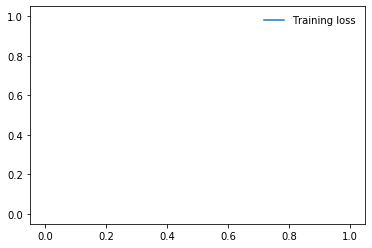

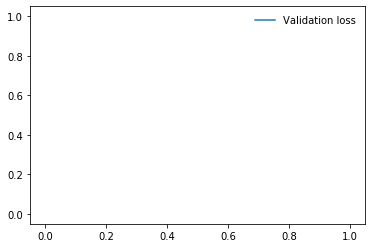

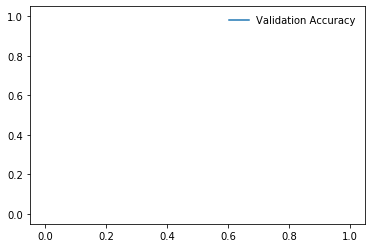

In [205]:
# Your plotting here

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)
plt.show()

plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

### Assignment 2.4 (BONUS): Showtime
A portion of the dataset has been held out from you. 

Show off your machine learning skills by designing and training your own network and competing for the best accuracy on the secret test set.

Some ideas to try:
1. Different recurrent network architectures ([LSTM](https://pytorch.org/docs/stable/nn.html#lstm), [GRU](https://pytorch.org/docs/stable/nn.html#gru))
2. Different hyper-parameters (Bi-Directionality, Recurrent Depth, Optimizer and Learning Rate)
3. Regularization ([Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers), Weight Decay)
4. Different spaCy models

Feel like doing something more advanced? Get in touch ;)

In [ ]:
# Your custom model and its functions here

NotImplemented